# ESMPy Tutorial
Nathan Wendt ([email](mailto:nawendt@ou.edu))  
Research Associate Meteorologist  
[OU CIMMS](http://cimms.ou.edu)/[NWS SPC](http://spc.noaa.gov)

ESMPy offers several features for taking data fields from one grid and interpolating it to another grid. Perhaps the easiest way is to load data in a SCRIP formatted file (most commonly seen in netCDF) into Python using this module. However, we do not always have our data formatted in this way. Many of us save our grids into less common formats (e.g., numpy compressed, etc.). What are we do do in these situations? Luckily, ESMPy has decent [documentation](https://www.earthsystemcog.org/projects/esmpy/esmpy_docs) and their email support is excellent.

Below is an example of how to do some common regridding tasks using ESMPy:

##### Imports

In [1]:
%matplotlib inline

from cartopy import crs, feature
import ESMF
from matplotlib import cm, gridspec, rcParams
# import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pyproj

Turn ESMF deubg output on.

In [2]:
ESMF.Manager(debug=True);

##### Data

In [3]:
# NAM
nam = np.load('nam_218_20120414_1200_006.npz')

# RUC
ruc = np.load('ruc2_130_20120414_1200_006.npz')

# SURFACE STATIONS
sfc = np.load('sfcstn_20120414_1800.npz')

# NAM CONUS MASK
nam_mask = np.load('nam_218_conus_mask.npz')

##### Grids

In [4]:
nam_lat = nam['lat']
nam_lon = nam['lon']
nam_p4s = nam['p4s'].tolist()

In [5]:
ruc_lat = ruc['lat']
ruc_lon = ruc['lon']
ruc_p4s = ruc['p4s'].tolist()

In [6]:
mask = nam_mask['mask']

In [7]:
# Dimension order for these arrays ar YX
nam_nx = nam_lat.shape[1]
nam_ny = nam_lat.shape[0]

ruc_nx = ruc_lat.shape[1]
ruc_ny = ruc_lat.shape[0]

#### Cartopy Projection Information

In [8]:
ruc_crs = crs.LambertConformal(globe=crs.Globe(semimajor_axis=ruc_p4s['a'], semiminor_axis=ruc_p4s['b']),
                               central_latitude=ruc_p4s['lat_0'], central_longitude=ruc_p4s['lon_0'],
                               standard_parallels=(ruc_p4s['lat_1'], ruc_p4s['lat_2']))

In [9]:
nam_crs = crs.LambertConformal(globe=crs.Globe(semimajor_axis=nam_p4s['a'], semiminor_axis=nam_p4s['b']),
                               central_latitude=nam_p4s['lat_0'], central_longitude=nam_p4s['lon_0'],
                               standard_parallels=(nam_p4s['lat_1'], nam_p4s['lat_2']))

Let's see how these two grids compare.

In [10]:
rcParams.update({'font.size': 14})

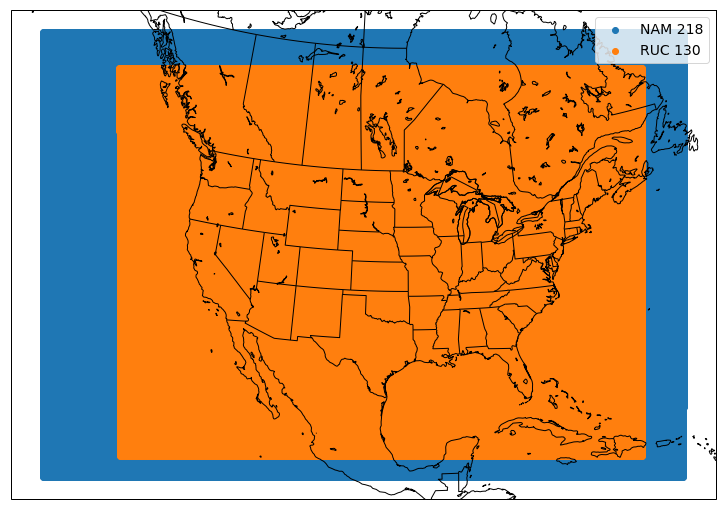

In [11]:
f1 = plt.figure(1,figsize=(16,9))
ax1 = plt.axes(projection=nam_crs)

ax1.scatter(nam_lon, nam_lat, transform=crs.PlateCarree(), label='NAM 218')
ax1.scatter(ruc_lon, ruc_lat, transform=crs.PlateCarree(), label='RUC 130')
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
plt.legend();

## Interpolating From One Grid to Another

A common regridding task is to take numerical model output on one grid and interpolate it to another. For this example, we will take 2 m dewpoint temperatures from the NAM and regrid it to the RUC grid. The example data are from April 14, 2012.

##### Initialize Grids

We will need to create `Grid` objects for the two model grids we are using. Our **sourcegrid** will be from the **NAM** and our **destination** grid will be from the **RUC**. Our coordinates will be in the center of our grid points. As we are using latitude and longitude values, we will be using spherical coordinates. If you have coordinates that are in projection space (typically in meters) then you must use `ESMF.CoordSys.CART` as the `coord_sys`. **If you are using Cartesian/projected coordinates, be sure both the source and destination grid are on the same projection. This is what ESMF assumes.**

**<span style="color:red">A note about efficient memory layout with ESMPy</span>**. As you will notice in a few places below, the coordinates and data being used are transposed (`.T`). The reason for this is that the exposed ESMF library subroutines being called are written in Fortran, not C (like `numpy`). Transposing the arrays just ensures that the arrays exist continguously in memory as they do natively in the ESMF Fortran subroutines. See this [gist](https://gist.github.com/JiaweiZhuang/e3f229db8262ee0d0314fcb4515f08ee) where this efficiency is shown with some performance metrics. While gaining performance is nice, it can decrease how intuitive the code is. Fortunately, I have set up a toggle below, `FORTRAN_CONTIGUOUS`. This way you can see how things are affected, follow the code easily, and do some of your own timings.

In [12]:
FORTRAN_CONTIGUOUS = True

In [13]:
if FORTRAN_CONTIGUOUS:
    nam_shape = nam_lat.T.shape
    ruc_shape = ruc_lat.T.shape
else:
    nam_shape = nam_lat.shape
    ruc_shape = ruc_lat.shape

In [14]:
sourcegrid = ESMF.Grid(np.array(nam_shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)

In [15]:
destgrid = ESMF.Grid(np.array(ruc_shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)

Right now, the `Grid` objects have default coordinate arrays set up based on the `coord_sys` and `staggerloc` arguments above. What they do not have are actual values (they are initialized to zero). We can add them easily by grabbing the 'pointers' to those coordinate arrays.

In [16]:
source_lon = sourcegrid.get_coords(0)
source_lat = sourcegrid.get_coords(1)

dest_lon = destgrid.get_coords(0)
dest_lat = destgrid.get_coords(1)

At this point we now have **pointers** to the _Grid_ object coordinates. Be careful not to overwrite the pointer variable here (i.e., you need to treat it like an array and use the `[]` accessor). You need to tell it to put the values into the array that is pointed to.

In [17]:
if FORTRAN_CONTIGUOUS:
    source_lon[...] = nam_lon.T
    source_lat[...] = nam_lat.T

    dest_lon[...] = ruc_lon.T
    dest_lat[...] = ruc_lat.T
else:
    source_lon[...] = nam_lon
    source_lat[...] = nam_lat

    dest_lon[...] = ruc_lon
    dest_lat[...] = ruc_lat

##### Initialize Fields

Once the `Grid` objects are created, we need to add data (at least to the source grid). To do this, we use `Field` objects.

In [18]:
sourcefield = ESMF.Field(sourcegrid, name='NAM 2 m DEWPOINT')

destfield = ESMF.Field(destgrid, name='RUC 2 m DEWPOINT')

Inserting the data is very simple. We will be using a 2 m dewpoint field (in Celsius) that was taken from the NAM grid.

In [19]:
if FORTRAN_CONTIGUOUS:
    sourcefield.data[...] = nam['dpc'].T
else:
    sourcefield.data[...] = nam['dpc']

##### Regrid

Now we need to initialize a `Regrid` object.

In [20]:
regrid = ESMF.Regrid(sourcefield, destfield, regrid_method=ESMF.RegridMethod.BILINEAR,  
                     unmapped_action=ESMF.UnmappedAction.IGNORE)

Initializing the regrid object calculates the weights that will map on grid to another.

In [21]:
destfield = regrid(sourcefield, destfield)

How does the interpolation compare to the original?

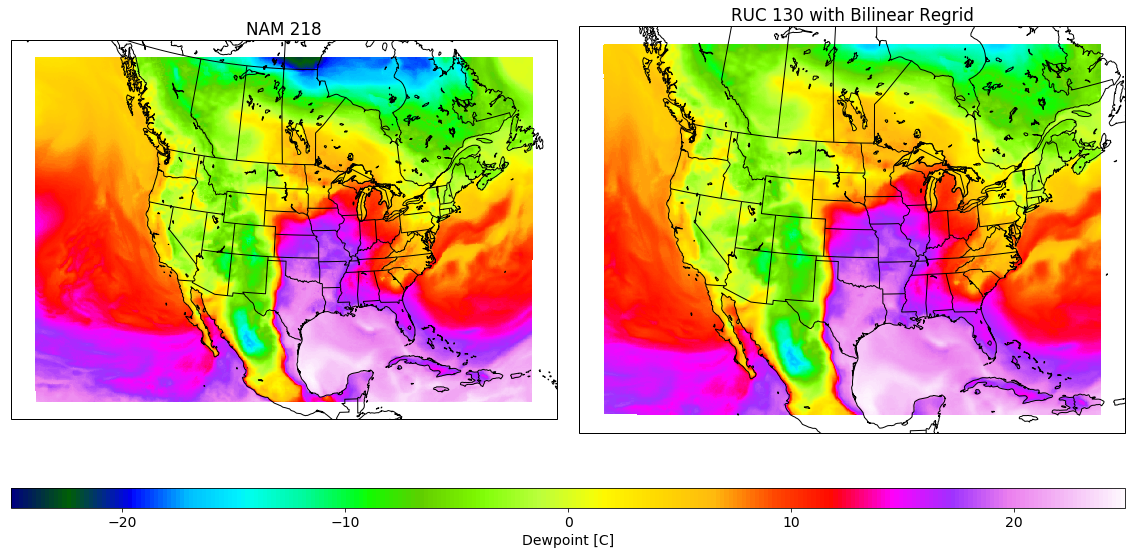

In [22]:
f2 = plt.figure(2, figsize=(16,9))
gs = gridspec.GridSpec(2, 2, height_ratios=(30,1))
ax1 = f2.add_subplot(gs[0], projection=nam_crs)

pcm = ax1.pcolormesh(source_lon, source_lat, sourcefield.data, cmap = 'gist_ncar',
               transform=crs.PlateCarree(), vmax = 25, vmin = -25)
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.set_title('NAM 218')

ax2 = f2.add_subplot(gs[1], projection=nam_crs)
ax2.pcolormesh(dest_lon, dest_lat, destfield.data, cmap = 'gist_ncar',
               transform=crs.PlateCarree(), vmax = 25, vmin = -25)
ax2.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.set_title('RUC 130 with Bilinear Regrid')

cbax = f2.add_subplot(gs[2:])
plt.colorbar(pcm, cax=cbax, orientation='horizontal', label='Dewpoint [C]')
plt.tight_layout()

###### Using Conservative Gridding

Other methods are also available for use such as first-order conservative and nearest-neighbor. The nearest-neighbor methods can be a bit slow with large grids--much slower than the bilinear method. Conservative regridding requires the corner coordinates for `Grid` objects. Nearest-neighbor methods are similar enough to the bilinear method that I will only give an example of the conservative method.

The first step to using conservative gridding with a `Grid` object is to define the corner locations of the grid. This is necessary as this gridding method needs to know the overlap between the source grid and the destination grid. Sometimes the model (or other data source) may give you the grid location coordinates and this will make your life much easier. In many other cases, however, you will have to create the grid corner coordinates yourself. This is what we will do in this example.

Getting the corner coordinates of a grid is fairly straightforward if you know the grid spacing and the projection information. Armed with that information, you can use the grid center coordinate information (which is what we have for this tutorial) and shift the coordinates appropriately to get the grid corners. Since we will be shifting coordinates based on the grid spacing and projection, we will need to use the `pyproj` package.

First, grab the lower-left latitude and longitude points. Of course, this assumes your numpy arrays are oriented such that the lower-left is in the [0, 0] location.

In [23]:
ruc_ll_lat = ruc_lat[0, 0]
ruc_ll_lon = ruc_lon[0, 0]

nam_ll_lat = nam_lat[0, 0]
nam_ll_lon = nam_lon[0, 0]

Then project the points and shift them by half the grid spacing in each dimension (in our case they are both the same).

In [24]:
ruc_proj = pyproj.Proj(**ruc_p4s)
nam_proj = pyproj.Proj(**nam_p4s)

In [25]:
ruc_proj_lon, ruc_proj_lat = ruc_proj(ruc_ll_lon, ruc_ll_lat)
nam_proj_lon, nam_proj_lat = nam_proj(nam_ll_lon, nam_ll_lat)

The grid spacing for the NAM and the RUC for these data are 12 km and 13 km, respectively. Again, the shift is only going to be half dx and dy. For NCEP model grids, the exact grid spacing can be found [here](http://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html).

In [26]:
ruc_dx = ruc_dy = 13545.087
nam_dx = nam_dy = 12190.58

ruc_proj_lat -= ruc_dy / 2
ruc_proj_lon -= ruc_dx / 2

nam_proj_lat -= ruc_dy / 2
nam_proj_lon -= ruc_dx / 2

I want to make special note of being aware of what units your dx and dy values are in. In this case, they are in meters and we can simply project our latitudes and longitudes and proceed as was shown above. However, some grids have cell spacing in units of degrees (e.g., many climate models, MRMS grids, etc.). In those cases the above approach to creating corners must be modified. Basically, in the case of dx and dy in degrees, you can omit the projection step and simply use the latitude and longitude values. It is important to be cognizant of the grid spacing units. This can be confusing when a grid with spacing in degrees gets described by its rough spacing in meters (i.e., the MRMS MESH grid has approximately 1 km grid spacing while being exactly 0.01 degrees in spacing).

Now we can create an array of the corner coordinates using the shifted lower-left corner and the horizontal grid spacing. The biggest thing to remember here is that the corner arrays will have one more point in each dimension. The illustration below shows why this is the case. The black dots represent the center grid location we already have coordinates for. The red dots are the corners.

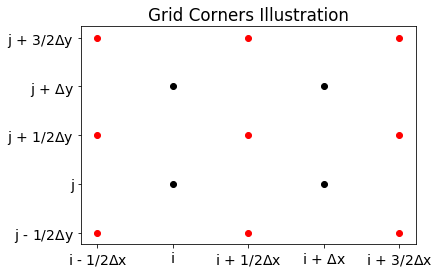

In [27]:
plt.scatter(np.repeat([1, 2, 3], 3), np.tile([1, 2, 3], 3), color='r')
plt.scatter(np.repeat([1.5, 2.5], 2), np.tile([1.5, 2.5], 2), color='k')
plt.xticks(np.arange(1, 3.5, 0.5), ['i - 1/2$\Delta$x', 'i', 'i + 1/2$\Delta$x', 'i + $\Delta$x', 'i + 3/2$\Delta$x'])
plt.yticks(np.arange(1, 3.5, 0.5), ['j - 1/2$\Delta$y', 'j', 'j + 1/2$\Delta$y', 'j + $\Delta$y', 'j + 3/2$\Delta$y'])
plt.title('Grid Corners Illustration');

In [28]:
ruc_corner_x = ruc_proj_lon + np.arange(ruc_nx + 1) * ruc_dx
ruc_corner_y = ruc_proj_lat + np.arange(ruc_ny + 1) * ruc_dy

nam_corner_x = nam_proj_lon + np.arange(nam_nx + 1) * nam_dx
nam_corner_y = nam_proj_lat + np.arange(nam_ny + 1) * nam_dy

Get the projected coordinates back into geographic coordinates. We will need to make a `meshgrid` of the coordinates to get a pair for each corner.

In [29]:
ruc_corner_lon, ruc_corner_lat = ruc_proj(*np.meshgrid(ruc_corner_x, ruc_corner_y), inverse=True)

nam_corner_lon, nam_corner_lat = nam_proj(*np.meshgrid(nam_corner_x, nam_corner_y), inverse=True)

To do the conservative regridding I will set up new grids. One easy is to use the `copy` method so you can be sure you are not making changes on the original grids. Then you could add the corner coordinates to the new `Grid` objects by specifying the appropriate `staggerloc`. The `add_coords` method will add all the appropriate dimensions based on what you specified `coord_sys` when you created the `Grid` object.

The other was is to simply pass all the coordinate locations you intend to define as a list to the `staggerloc` parameter. This allows you to skip the `add_coords` step above.

In [30]:
sourcegrid_conserve = ESMF.Grid(np.array(nam_shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER],
                                coord_sys=ESMF.CoordSys.SPH_DEG)

destgrid_conserve = ESMF.Grid(np.array(ruc_shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER],
                              coord_sys=ESMF.CoordSys.SPH_DEG)

Add the grid center coordinates as before. The default `staggerloc` will be the center, but we can be explicit, too.

In [31]:
source_con_lon = sourcegrid_conserve.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
source_con_lat = sourcegrid_conserve.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)

dest_con_lon = destgrid_conserve.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
dest_con_lat = destgrid_conserve.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)

source_con_lon[...] = source_lon
source_con_lat[...] = source_lat

dest_con_lon[...] = dest_lon
dest_con_lat[...] = dest_lat

Get the pointers to the corner coordinate arrays.

In [32]:
nc_lat = sourcegrid_conserve.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
nc_lon = sourcegrid_conserve.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)

rc_lat = destgrid_conserve.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
rc_lon = destgrid_conserve.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)

In [33]:
if FORTRAN_CONTIGUOUS:
    nc_lat[...] = nam_corner_lat.T
    nc_lon[...] = nam_corner_lon.T

    rc_lat[...] = ruc_corner_lat.T
    rc_lon[...] = ruc_corner_lon.T
else:
    nc_lat[...] = nam_corner_lat
    nc_lon[...] = nam_corner_lon

    rc_lat[...] = ruc_corner_lat
    rc_lon[...] = ruc_corner_lon

Let's create a new `Field` instance for easier comparison later.

In [34]:
sourcefield_conserve = ESMF.Field(sourcegrid_conserve, name='NAM 2 m DEWPOINT')

destfield_conserve = ESMF.Field(destgrid_conserve, name='RUC 2 m DEWPOINT')

In [35]:
if FORTRAN_CONTIGUOUS:
    sourcefield_conserve.data[...] = nam['dpc'].T
else:
    sourcefield_conserve.data[...] = nam['dpc']

With the corner coordinates now defined, we can use conservative gridding.

In [36]:
regrid_conserve = ESMF.Regrid(sourcefield_conserve, destfield_conserve, regrid_method=ESMF.RegridMethod.CONSERVE,  
                     unmapped_action=ESMF.UnmappedAction.IGNORE)

In [37]:
destfield_conserve = regrid_conserve(sourcefield_conserve, destfield_conserve)

Again, compare it to the original NAM data.

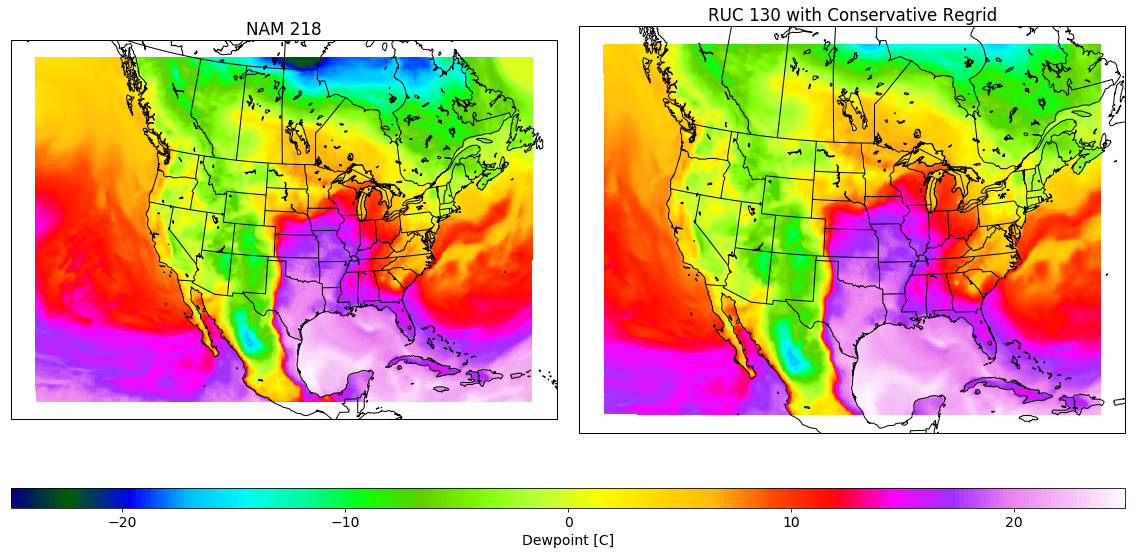

In [38]:
f3 = plt.figure(2, figsize=(16,9))
gs = gridspec.GridSpec(2, 2, height_ratios=(30,1))
ax1 = f3.add_subplot(gs[0], projection=nam_crs)

pcm = ax1.pcolormesh(source_lon, source_lat, sourcefield_conserve.data, cmap = 'gist_ncar',
               transform=crs.PlateCarree(), vmax = 25, vmin = -25)
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.set_title('NAM 218')

ax2 = f3.add_subplot(gs[1], projection=nam_crs)
ax2.pcolormesh(dest_lon, dest_lat, destfield_conserve.data, cmap = 'gist_ncar',
               transform=crs.PlateCarree(), vmax = 25, vmin = -25)
ax2.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.set_title('RUC 130 with Conservative Regrid')

cbax = f3.add_subplot(gs[2:])
plt.colorbar(pcm, cax=cbax, orientation='horizontal', label='Dewpoint [C]')
plt.tight_layout()

Let's compare the bilinear and conservative RUC regrids.

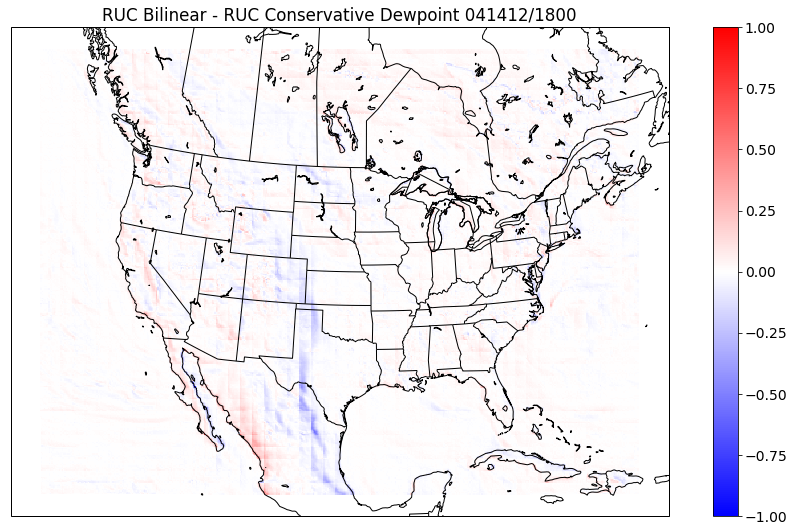

In [39]:
f4 = plt.figure(4, figsize=(16,9))
ax1 = plt.axes(projection=ruc_crs)

pcm = ax1.pcolormesh(dest_lon, dest_lat, destfield.data - destfield_conserve.data, cmap = 'bwr',
                     transform=crs.PlateCarree(), vmax = 1, vmin = -1)
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.set_title('RUC Bilinear - RUC Conservative Dewpoint 041412/1800')
plt.colorbar(pcm, ax=ax1);

## Interpolating Points to a Grid

Above, we loaded some surface station data that is not on any grid. We can regrid that to one of the model grids.

In [40]:
sourceloc = ESMF.LocStream(len(sfc['dpc']), coord_sys=ESMF.CoordSys.SPH_DEG, 
                           name='Surface Station Dewpoint')

Now we will need to add the coordinates. In `LocStream` objects (unstructured points), these are accessed using dictionary keys. No need to do any transpose operations as these arrays will be 1-dimensional.

In [41]:
sourceloc['ESMF:Lat'] = sfc['lat']
sourceloc['ESMF:Lon'] = sfc['lon']

In this case, the surface data has some missing points. They are denoted by values of -9999. We can easily mask these values.

In [42]:
# Where are the missing data?
missing = -9999
miss_loc = (sfc['dpc'] != missing).astype(np.int32)

# Define the mask in the LocStream
sourceloc['ESMF:Mask'] = miss_loc

In order to insert the data and do the regrid of the points, we need to make a `Field` object based on our `LocStream` object.

In [43]:
sourcefield_pts = ESMF.Field(sourceloc, name='Surface Station Dewpoints')
sourcefield_pts.data[...] = sfc['dpc']

Because we now have data that does not extend beyond the CONUS, it would wise to add a mask to avoid undesired extrapolation. We can add a mask to the original NAM grid and use it here.

In [44]:
sourcegrid_masked = sourcegrid.copy()
source_mask = sourcegrid_masked.add_item(ESMF.GridItem.MASK)
if FORTRAN_CONTIGUOUS:
    source_mask[...] = mask.T
else:
    source_mask[...] = mask

Create a new `Grid` and `Regrid` objects and proceed as before.

In [45]:
destfield2 = ESMF.Field(sourcegrid_masked, name='ASOS to NAM 218 Dewpoints')

# Initialize destination field to value outside data range for easy masking later
destfield2.data[...] = 1e20

As of right now, only **nearest neighbor** interpolation can be used when using `LocStream` objects for the source data.

In [46]:
regrid2 = ESMF.Regrid(sourcefield_pts,destfield2, regrid_method=ESMF.RegridMethod.NEAREST_STOD, 
                      unmapped_action=ESMF.UnmappedAction.IGNORE, dst_mask_values=np.array([0,-9999]))

In [47]:
# Use the ESMF.Region.SELECT to leave unmapped points as their current values (which will be 1e20)
destfield2 = regrid2(sourcefield_pts, destfield2, zero_region=ESMF.Region.SELECT)

How do the gridded surface observations compare to the model forecast field?

In [48]:
# First, some masking voodoo for comparison purposes
nam_masked = np.ma.array(sourcefield.data)
if FORTRAN_CONTIGUOUS:
    nam_masked.mask = ~np.ma.make_mask(mask.T)
else:
    nam_masked.mask = ~np.ma.make_mask(mask)

# Because we initially set the field to 1e20, we can 
# now use that to mask outside the CONUS easily without
# worrying about taking out real data
asos_masked = np.ma.masked_equal(destfield2.data, 1e20)
asos_masked = np.ma.masked_equal(asos_masked, -9999.0)

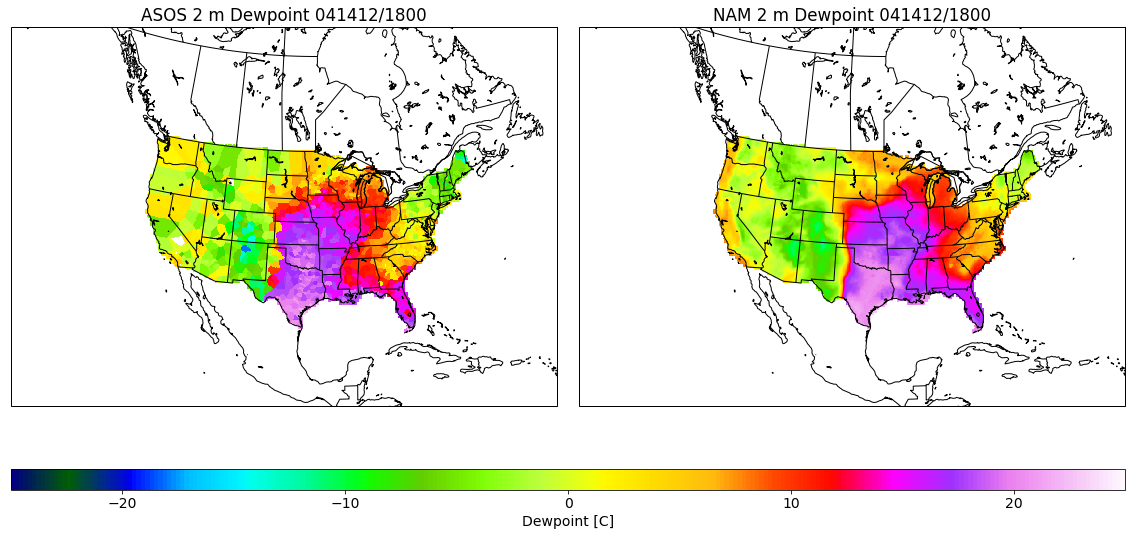

In [49]:
f5 = plt.figure(5, figsize=(16,9))
gs = gridspec.GridSpec(2, 2, height_ratios=(30,1))
ax1 = f5.add_subplot(gs[0], projection=nam_crs)

pcm = ax1.pcolormesh(source_lon, source_lat, asos_masked, cmap = 'gist_ncar',
               transform=crs.PlateCarree(), vmax = 25, vmin = -25)
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.set_title('ASOS 2 m Dewpoint 041412/1800')

ax2 = f5.add_subplot(gs[1], projection=nam_crs)
ax2.pcolormesh(source_lon, source_lat, nam_masked, cmap = 'gist_ncar',
               transform=crs.PlateCarree(), vmax = 25, vmin = -25)
ax2.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax2.set_title('NAM 2 m Dewpoint 041412/1800')

cbax = f5.add_subplot(gs[2:])
plt.colorbar(pcm, cax=cbax, orientation='horizontal', label='Dewpoint [C]')
plt.tight_layout()

And in a difference plot...

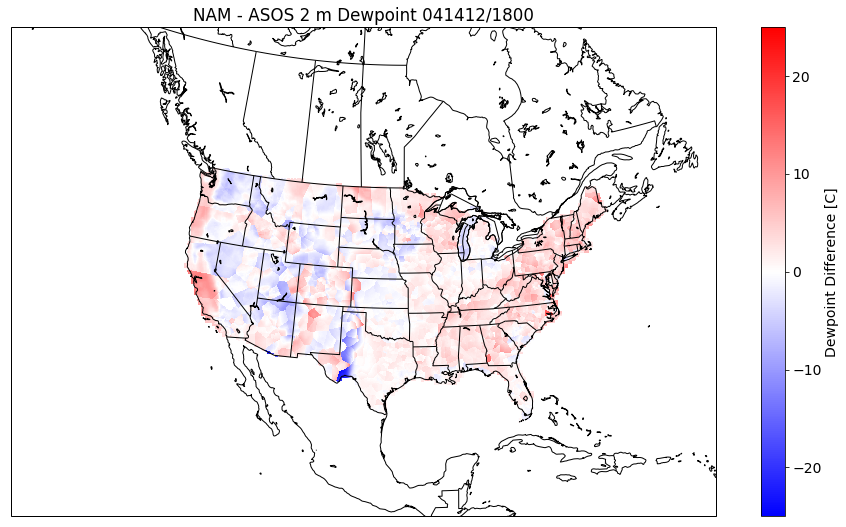

In [50]:
f6 = plt.figure(6, figsize=(16,9))
ax1 = plt.axes(projection=nam_crs)

pcm = ax1.pcolormesh(source_lon, source_lat, nam_masked - asos_masked, cmap = 'bwr',
                     transform=crs.PlateCarree(), vmax = 25, vmin = -25)
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='lakes',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='physical',
                                            name='coastline',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_0_boundary_lines_land',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black'))
ax1.set_title('NAM - ASOS 2 m Dewpoint 041412/1800')
plt.colorbar(pcm, ax=ax1, label='Dewpoint Difference [C]');

## Grid to LocStream

Another useful operation we can do with ESMPy is to pull values from specific points. Let's set up a few coordinates for some cities.

In [51]:
topeka = (39.055833, -95.689444)
dodge_city = (37.759722, -100.018333)
salina = (38.840278, -97.611389)
dallas = (32.775833, -96.796667)
norman = (35.22, -97.44)

In [52]:
town_lat = np.array([topeka[0], dodge_city[0], salina[0], dallas[0], norman[0]])
town_lon = np.array([topeka[1], dodge_city[1], salina[1], dallas[1], norman[1]])

Create the `LocStream` and populate the coordinates.

In [53]:
town_loc = ESMF.LocStream(5, coord_sys = ESMF.CoordSys.SPH_DEG, name = 'Town Locations')

In [54]:
town_loc['ESMF:Lat'] = town_lat
town_loc['ESMF:Lon'] = town_lon

Again, create a `Field` based on the town `LocStream`.

In [55]:
town_data = ESMF.Field(town_loc, name = 'Town 2 m NAM Dewpoint')

Regrid using the NAM 2 M dewpoint data that we have from earlier.

In [56]:
regrid3 = ESMF.Regrid(sourcefield,town_data, regrid_method = ESMF.RegridMethod.BILINEAR, 
                      unmapped_action = ESMF.UnmappedAction.IGNORE)

In [57]:
town_data = regrid3(sourcefield, town_data)

And display the data.

In [58]:
print("""
--- Extracted NAM 2 m Dewpoints ---
Topeka, KS     : {:5.3f} C
Dodge City, KS : {:5.3f} C
Salina, KS     : {:5.3f} C
Dallas, TX     : {:5.3f} C
Norman, OK     : {:5.3f} C
""".format(*town_data.data))


--- Extracted NAM 2 m Dewpoints ---
Topeka, KS     : 17.687 C
Dodge City, KS : 16.307 C
Salina, KS     : 17.007 C
Dallas, TX     : 19.625 C
Norman, OK     : 19.446 C



## Regrid In Parallel

When your `Grid` dimensions get large, it becomes very time consuming to calculate regridding weights. Fortunately, ESMPy (within the ESMF library itself) works very cleanly and easily with MPI and the `mpi4py` package. Included in this tutorial is an example script, called **esmpy_mpi_example.py**, that can be run with the following shell command,

```bash
mpirun -n NPROCS python esmpy_mpi_example.py
```

where NPROCS is the number of processes you want to spawn (NPROCS $\le$ the number of processors on your computer, generally). Other than the imported packages above, you will need to have `mpi4py` installed for the script to function properly.

**NOTE**: You may need to build mpi4py and ESMF from source (as opposed to using conda, for example) so that they work with your particular MPI library. Building from source will be more likely if you are working on an HPC cluster or something similar. On those machines, the MPI installations have been tuned to work with the machine's architecture. Source builds of the ESMF library *do not* build using MPI by default. Performance can suffer if the proper libraries are not used.

## Other Features

ESMPy also has other capabilities not shown here. For example,
+ Regrid to and from meshes (think MPAS!)
+ Read from files (netCDF, etc.) and automatically set up coordinates